In [0]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm as tqdm_

In [2]:
# set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [0]:
# define dataset

class SensorlessDataset(Dataset):
  
  def __init__(self, dataframe):
    self.dataset = dataframe.values
    self.dataset = torch.tensor(self.dataset)
    
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    return self.dataset[idx, :-1].float(), self.dataset[idx, -1].long()


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# load data
data_filename = 'gdrive/My Drive/Colab Notebooks/OnlineNewsPopularity/HW2/data/Sensorless_drive_diagnosis.txt'
df = pd.read_csv(data_filename, delimiter=' ', header=None)

In [6]:
# shift class by 1
df['class'] = df[48] - 1

# print number of samples in each class
print('number of samples in each class:\n\n', df['class'].value_counts())

# drop column in -2
df.drop(df.columns[-2], axis=1, inplace=True)


number of samples in each class:

 10    5319
9     5319
8     5319
7     5319
6     5319
5     5319
4     5319
3     5319
2     5319
1     5319
0     5319
Name: class, dtype: int64


In [0]:
# shuffle
df = df.sample(frac=1, random_state=123).reset_index(drop=True)

In [0]:
# define model

class Model(nn.Module):
  def __init__(self, num_features, num_classes):
    super(Model, self).__init__()
    
    self.fc1 = nn.Linear(num_features, 64)
    self.relu1 = nn.ReLU()
    self.batchnorm1 = nn.BatchNorm1d(64)
    self.fc2 = nn.Linear(64, 128)
    self.relu2 = nn.ReLU()
    self.batchnorm2 = nn.BatchNorm1d(128)
    self.fc3 = nn.Linear(128, 256)
    self.relu3 = nn.ReLU()
    self.batchnorm3 = nn.BatchNorm1d(256)
    self.fc4 = nn.Linear(256, 256)
    self.relu4 = nn.ReLU()
    self.fc5 = nn.Linear(256, 128)
    self.relu5 = nn.ReLU()
    self.fc6 = nn.Linear(128, 64)
    self.relu6 = nn.ReLU()
    self.fc7 = nn.Linear(64, num_classes)
    
  def forward(self, x):
    x = self.batchnorm1(self.relu1(self.fc1(x)))
    x = self.batchnorm2(self.relu2(self.fc2(x)))
    x = self.batchnorm3(self.relu3(self.fc3(x)))
    x = self.relu4(self.fc4(x))
    x = self.relu5(self.fc5(x))
    x = self.relu6(self.fc6(x))
    x = self.fc7(x)
    return x

In [0]:
# define train method

def train(data_loader, model, optimizer, criterion, curr_epoch, tot_epochs, device):
  
  # set model to training mode
  model.train()
  
  tot_train_loss = 0.0
  
  train_meter = tqdm(
      data_loader, unit=' batches',
      desc=f'[Epoch {curr_epoch}/{tot_epochs}]',
      leave=False
  )
  
  for batch_idx, (sample, label) in enumerate(train_meter):
    
    # transfer to device
    sample, label = sample.to(device), label.to(device)
    
    # zero out gradients
    optimizer.zero_grad()
    
    # forward pass
    out = model(sample)
    
    # compute loss
    loss = criterion(out, label)
    
    # backward
    loss.backward()
    
    # optimizer step
    optimizer.step()
    
    # update tqdm meter
    train_meter.set_postfix(train_loss=f'{loss.item():0.4f}')
    train_meter.update()
    
    # add to total train loss
    tot_train_loss = tot_train_loss + loss.item()
    
  av_train_loss = tot_train_loss / (batch_idx + 1)
  return av_train_loss

In [0]:
# define validation method

def validate(data_loader, model, criterion, device):
  
  # set model to eval mode
  model.eval()
  
  tot_val_loss = 0.0
  corrects = 0
  total = 0
  
  val_meter = tqdm(
      data_loader, unit=' batches',
      desc='val',
      leave=False
  )
  
  with torch.no_grad():
    for batch_idx, (sample, label) in enumerate(val_meter):

      # transfer to device
      sample, label = sample.to(device), label.to(device)

      # forward pass
      out = model(sample)

      # compute loss
      loss = criterion(out, label)
      
      # compute the prediction
      max_value, pred = torch.max(out, dim=-1)
      
      # compute number of correct predictions
      corrects += (pred == label).sum().item()

      # update total samples
      total = total + len(label)

      # update tqdm meter
      val_meter.set_postfix(val_loss=f'{loss.item():0.4f}')
      val_meter.update()

      # add to total val loss
      tot_val_loss = tot_val_loss + loss.item()

  av_val_loss = tot_val_loss / (batch_idx + 1)
  accuracy = corrects / total
  return av_val_loss, accuracy

In [0]:
# specify learning rate
learning_rate = 0.01

# specify criterion
criterion = nn.CrossEntropyLoss()

In [12]:
all_train_losses = []
all_val_losses = []
all_accs = []
all_best_accs = []
for cv_idx, cv in enumerate([4000, 5000, 7000, 8000, 9000]):

  print(89 * '-')
  print(f'Training fold {cv_idx + 1}')
  print(89 * '-')

  # split into train, val and test
  df_train, df_val, df_test = df.loc[cv:], df.loc[cv - 1000: cv - 1], df.loc[:999]

  # create datasets
  train_dataset = SensorlessDataset(df_train)
  val_dataset = SensorlessDataset(df_val)
  test_dataset = SensorlessDataset(df_test)

  # create data loaders
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

  # create model object
  model = Model(num_features=48, num_classes=11)

  # transfer model to device
  model = model.to(device)

  # create optimizer
  optimizer = torch.optim.Adam(
      filter(lambda param: param.requires_grad, model.parameters()),
      lr=learning_rate
  )

  # specify max number of epochs
  num_epochs = 30

  train_losses, val_losses, accs = [], [], []

  min_val_loss = np.inf
  best_acc = -1
  for epoch in range(1, num_epochs + 1):
    train_loss = train(train_loader, model, optimizer, criterion, epoch, num_epochs, device)
    val_loss, accuracy = validate(val_loader, model, criterion, device)

    if val_loss <= min_val_loss:
      min_val_loss = val_loss
      best_acc = accuracy
    
    # check for early stopping
    if all(val_loss > loss for loss in val_losses[-3:]) and len(val_losses) > 2: 
      print('stopping early')
      break
    
    # save losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accs.append(accuracy)
    
    # print losses and accuracies
    tqdm_.write(f'[Epoch {epoch}/{num_epochs}] train loss: {train_loss:0.4f}, val loss: {val_loss:0.4f}, accuracy: {accuracy * 100:0.2f} %')
  
  all_train_losses.append(train_losses)
  all_val_losses.append(val_losses)
  all_accs.append(accs)
  all_best_accs.append(best_acc)


-----------------------------------------------------------------------------------------
Training fold 1
-----------------------------------------------------------------------------------------


[Epoch 1/30] train loss: 1.3335, val loss: 1.0948, accuracy: 47.70 %


[Epoch 2/30] train loss: 1.0656, val loss: 0.8424, accuracy: 62.20 %


[Epoch 3/30] train loss: 0.7330, val loss: 0.5975, accuracy: 75.80 %


[Epoch 4/30] train loss: 0.5333, val loss: 0.4102, accuracy: 85.00 %


stopping early
-----------------------------------------------------------------------------------------
Training fold 2
-----------------------------------------------------------------------------------------


[Epoch 1/30] train loss: 1.2902, val loss: 1.2935, accuracy: 41.40 %


[Epoch 2/30] train loss: 1.0012, val loss: 0.9863, accuracy: 66.80 %


[Epoch 3/30] train loss: 0.6389, val loss: 0.4589, accuracy: 81.30 %


[Epoch 4/30] train loss: 0.4922, val loss: 0.6462, accuracy: 75.70 %


[Epoch 5/30] train loss: 0.4511, val loss: 0.3837, accuracy: 85.20 %


stopping early
-----------------------------------------------------------------------------------------
Training fold 3
-----------------------------------------------------------------------------------------


[Epoch 1/30] train loss: 1.3497, val loss: 0.9890, accuracy: 53.80 %


[Epoch 2/30] train loss: 1.0275, val loss: 1.1894, accuracy: 45.80 %


[Epoch 3/30] train loss: 0.9166, val loss: 0.6892, accuracy: 67.30 %


[Epoch 4/30] train loss: 0.5956, val loss: 0.4230, accuracy: 84.40 %


[Epoch 5/30] train loss: 0.5024, val loss: 0.4381, accuracy: 83.60 %


stopping early
-----------------------------------------------------------------------------------------
Training fold 4
-----------------------------------------------------------------------------------------


[Epoch 1/30] train loss: 1.3172, val loss: 1.0965, accuracy: 48.20 %


[Epoch 2/30] train loss: 0.9265, val loss: 0.7026, accuracy: 69.20 %


[Epoch 3/30] train loss: 0.5787, val loss: 0.7172, accuracy: 67.80 %


[Epoch 4/30] train loss: 0.4987, val loss: 0.4849, accuracy: 82.70 %


[Epoch 5/30] train loss: 0.4710, val loss: 0.6150, accuracy: 82.70 %


stopping early
-----------------------------------------------------------------------------------------
Training fold 5
-----------------------------------------------------------------------------------------


[Epoch 1/30] train loss: 2.3996, val loss: 2.3983, accuracy: 10.30 %


[Epoch 2/30] train loss: 2.3990, val loss: 2.3980, accuracy: 8.90 %


[Epoch 3/30] train loss: 2.3989, val loss: 2.3979, accuracy: 8.70 %


[Epoch 4/30] train loss: 2.3989, val loss: 2.3975, accuracy: 9.20 %


stopping early


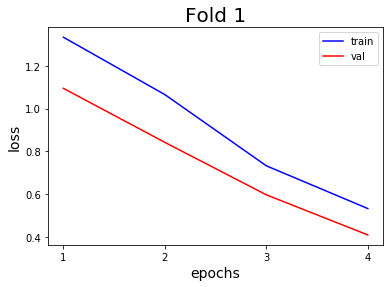

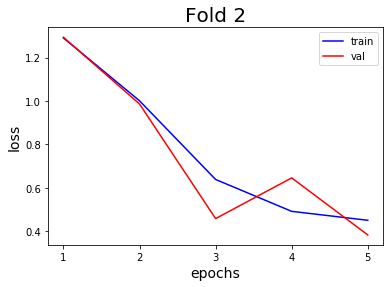

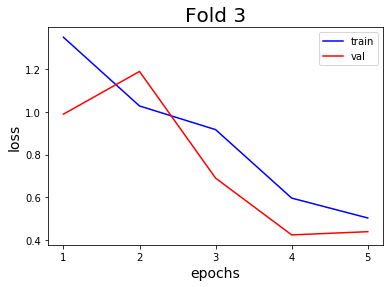

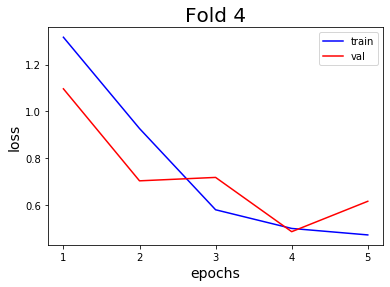

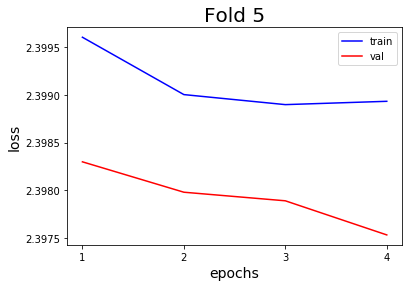

In [13]:
# plot losses
for cv_idx in range(5):
  train_losses = all_train_losses[cv_idx]
  val_losses = all_val_losses[cv_idx]
  assert len(train_losses) == len(val_losses), 'number of training epochs and validation losses differ'
  plt.plot(range(1, len(train_losses) + 1), train_losses, label='train', c='blue')
  plt.plot(range(1, len(val_losses) + 1), val_losses, label='val', c='red')
  
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel('loss', fontsize=14)
  plt.title(f'Fold {cv_idx + 1}', fontsize=20)
  plt.xticks(range(1, len(train_losses) + 1))
  plt.legend()
  plt.show()

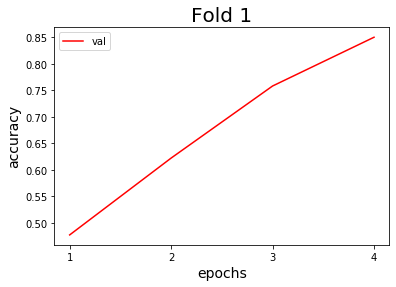

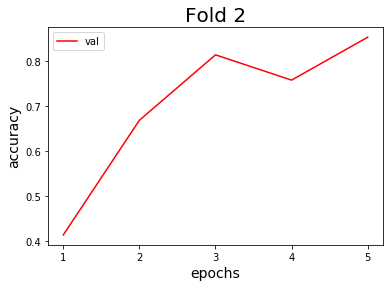

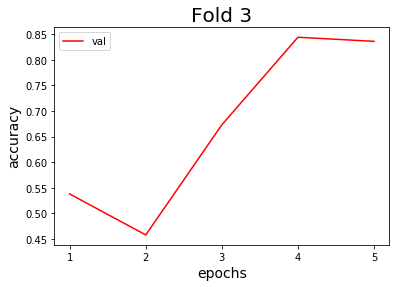

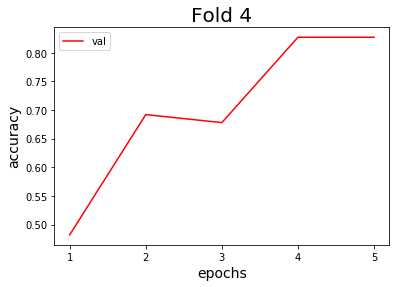

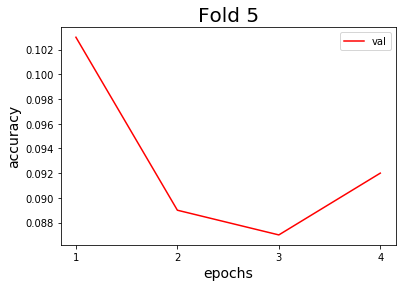

In [14]:
# plot accuracies
for cv_idx in range(5):
  accs = all_accs[cv_idx]
  plt.plot(range(1, len(accs) + 1), accs, label='val', c='red')
  plt.legend()
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel('accuracy', fontsize=14)
  plt.title(f'Fold {cv_idx + 1}', fontsize=20)
  plt.xticks(range(1, len(accs) + 1))
  plt.show()